In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우의 한글 폰트
plt.rcParams['axes.unicode_minus'] = False       # 마이너스 기호 깨짐 방지

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터 처리
import pandas as pd
import numpy as np

train_df = pd.read_csv("/data/train.csv")
test_df = pd.read_csv("/data/test.csv")

# 새로운 조합 변수 추가
for df in [train_df, test_df]:
    df['신용한도_대비_미상환율'] = df['현재 미상환 신용액'] / (df['최대 신용한도'] + 1)
    df['연체_빈도율'] = df['신용 문제 발생 횟수'] / (df['신용 거래 연수'] + 1)
    df['소득_대비_월_부채'] = df['월 상환 부채액'] / (df['연간 소득'] / 12 + 1)
    df['부채비율'] = df['현재 대출 잔액'] / (df['연간 소득'] + 1)
    # df['총부채_소득비율'] = (df['현재 대출 잔액'] + df['현재 미상환 신용액']) / (df['연간 소득'] + 1)
    df['개인파산_영향력'] = df['개인 파산 횟수'] * df['신용 문제 발생 횟수']


# "UID" 컬럼 유지 (제출 파일용)
test_uid = test_df["UID"]

# "UID" 컬럼 삭제
train_df.drop(columns=["UID"], inplace=True)
test_df.drop(columns=["UID"], inplace=True)

# X, y 분리
X = train_df.drop(columns=["채무 불이행 여부"])
y = train_df["채무 불이행 여부"]

In [3]:
# def convert_years(val):
#     if val == '1년 미만':
#         return 0
#     elif val == '10년 이상':
#         return 10
#     else:
#         # '4년', '6년' 등에서 '년'을 제거하고 정수형으로 변환
#         return int(val.replace('년', ''))

# # train, test 데이터에 대해 변환 적용
# X['현재 직장 근속 연수'] = X['현재 직장 근속 연수'].apply(convert_years)
# test_df['현재 직장 근속 연수'] = test_df['현재 직장 근속 연수'].apply(convert_years)

# # 변환 결과 확인
# print(X['현재 직장 근속 연수'].unique())


# 현재 직장 근속 연수를 이진 변수로 변환 (1년 미만: 1, 1년 이상: 0)
X['근속연수_1년미만'] = (X['현재 직장 근속 연수'] == '1년 미만').astype(int)
test_df['근속연수_1년미만'] = (test_df['현재 직장 근속 연수'] == '1년 미만').astype(int)

# 기존 변수 제거
X.drop(columns=['현재 직장 근속 연수'], inplace=True)
test_df.drop(columns=['현재 직장 근속 연수'], inplace=True)


In [4]:
# 원-핫 인코딩 적용
X = pd.get_dummies(X, columns=["주거 형태", "대출 목적", "대출 상환 기간"], drop_first=True)
test_df = pd.get_dummies(test_df, columns=["주거 형태", "대출 목적", "대출 상환 기간"], drop_first=True)

In [5]:
# from sklearn.model_selection import KFold

# # 타깃 인코딩을 적용할 범주형 변수 목록
# target_encoding_cols = ['주거 형태', '대출 목적', '대출 상환 기간']

# kf = KFold(n_splits=5, shuffle=True, random_state=31)

# for col in target_encoding_cols:
#     target_mean_map = {}

#     for train_idx, val_idx in kf.split(X):
#         train_fold, val_fold = X.iloc[train_idx], X.iloc[val_idx]
#         y_train_fold = y.iloc[train_idx]  # 🔹 y도 동일한 인덱싱으로 분할

#         # 🔹 타깃 평균 계산 (X_train과 y를 합쳐서 groupby)
#         train_fold = train_fold.copy()
#         train_fold['y'] = y_train_fold  # 🔥 여기서 y 값을 추가!

#         mean_encoding = train_fold.groupby(col)['y'].mean().to_dict()
#         target_mean_map.update(mean_encoding)

#     # 새로운 타깃 인코딩 컬럼 추가
#     X[col + '_타깃인코딩'] = X[col].map(target_mean_map)
#     test_df[col + '_타깃인코딩'] = test_df[col].map(target_mean_map)

# # 원본 범주형 컬럼 삭제
# X.drop(columns=target_encoding_cols, inplace=True)
# test_df.drop(columns=target_encoding_cols, inplace=True)

# print("✅ 타깃 인코딩 적용 완료!")


In [6]:
# # 중요도가 낮은 "대출 목적" 컬럼들 제거
# drop_loan_purpose_cols = [
#     '대출 목적_사업 대출', '대출 목적_여행 자금', 
#     '대출 목적_주택 개보수', '대출 목적_주택 구매'
# ]

# # 변수 삭제
# X.drop(columns=drop_loan_purpose_cols, inplace=True)
# test_df.drop(columns=drop_loan_purpose_cols, inplace=True)


In [7]:
# 로그 변환
log_columns = ["현재 미상환 신용액", "월 상환 부채액", "현재 대출 잔액", "연간 소득",
               '신용한도_대비_미상환율', '소득_대비_월_부채', '부채비율'] # 최대 신용한도 컬럼도 추가 가능
for col in log_columns:
    X[col] = np.log1p(X[col])
    test_df[col] = np.log1p(test_df[col])

# "마지막 연체 이후 경과 개월 수"가 0이면 "연체 없음" 컬럼 추가
# X["연체 없음"] = (X["마지막 연체 이후 경과 개월 수"] == 0).astype(int)
# test_df["연체 없음"] = (test_df["마지막 연체 이후 경과 개월 수"] == 0).astype(int)

In [8]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)
test_imputed = imputer.transform(test_df)

# from sklearn.impute import KNNImputer

# imputer = KNNImputer(n_neighbors=5)
# X_imputed = imputer.fit_transform(X)
# test_imputed = imputer.transform(test_df)

In [9]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_imputed)
# test_scaled = scaler.transform(test_imputed)

In [10]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# smote = SMOTE(random_state=64, sampling_strategy=0.8)
# X_imputed, y = smote.fit_resample(X_imputed, y)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 스케일링 + 로지스틱 회귀 파이프라인
log_reg = Pipeline([
    ('scaler', StandardScaler()),  # 표준화
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42))
])

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# 하이퍼파라미터 후보
param_grid = {
    'classifier__C': [1]  # 규제 강도 (낮을수록 강한 규제)
}

# 그리드 서치 적용
grid_search = GridSearchCV(log_reg, param_grid, scoring='roc_auc', cv=5, verbose=1)
grid_search.fit(X_imputed, y)

# 최적 모델 선택
best_model = grid_search.best_estimator_
print("최적의 하이퍼파라미터:", grid_search.best_params_)
print("Best CV ROC-AUC:", grid_search.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
최적의 하이퍼파라미터: {'classifier__C': 1}
Best CV ROC-AUC: 0.7191510797834552


In [13]:
# 로지스틱 회귀를 사용해 테스트 데이터 예측
test_pred = grid_search.predict_proba(test_df)[:, 1]  # 양성 클래스(채무 불이행)의 확률

# 제출 파일 생성
submission = pd.DataFrame({
    'UID': test_uid,
    '채무 불이행 확률': test_pred
})

# CSV 파일 저장
submission.to_csv('/data/submission.csv', index=False)
print("✅ 'submission.csv' 파일이 '/data' 경로에 저장되었습니다.")

✅ 'submission.csv' 파일이 '/data' 경로에 저장되었습니다.


In [14]:
submission[submission['채무 불이행 확률'] < 0.5]

,UID,채무 불이행 확률
0,TEST_0000,0.432469
1,TEST_0001,0.449806
2,TEST_0002,0.473444
3,TEST_0003,0.247389
5,TEST_0005,0.408265
...,...,...
2055,TEST_2055,0.374889
2056,TEST_2056,0.476770
2057,TEST_2057,0.321198
2058,TEST_2058,0.378659


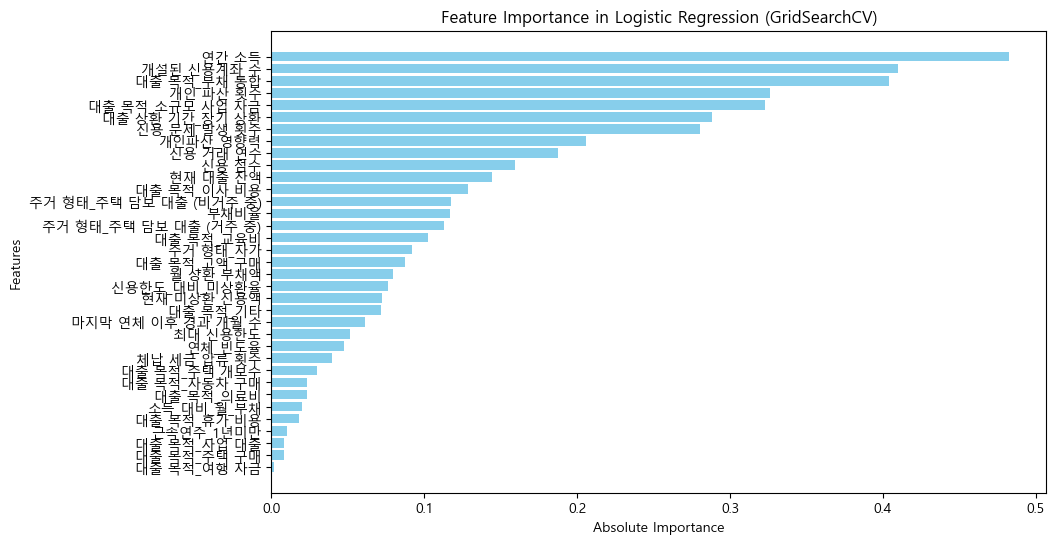

                   Feature  Importance
0                    연간 소득   -0.482659
2               개설된 신용계좌 수    0.409519
24             대출 목적_부채 통합    0.403939
7                 개인 파산 횟수    0.326391
26         대출 목적_소규모 사업 자금   -0.322960
34          대출 상환 기간_장기 상환    0.288159
5              신용 문제 발생 횟수    0.280107
16                개인파산_영향력   -0.205560
3                 신용 거래 연수   -0.187215
11                   신용 점수   -0.159563
8                 현재 대출 잔액    0.144076
29             대출 목적_이사 비용   -0.128803
20  주거 형태_주택 담보 대출 (비거주 중)   -0.117850
15                    부채비율   -0.116926
19   주거 형태_주택 담보 대출 (거주 중)   -0.113179
22               대출 목적_교육비   -0.102442
18                주거 형태_자가   -0.091902
21             대출 목적_고액 구매   -0.087456
10                월 상환 부채액    0.079836
12            신용한도_대비_미상환율   -0.076626
9               현재 미상환 신용액    0.072516
23                대출 목적_기타    0.072002
6        마지막 연체 이후 경과 개월 수   -0.061137
4                  최대 신용한도   -0.051346
13                  연체_빈도

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

feature_cols = X.columns

# 최적 모델 가져오기
best_model = grid_search.best_estimator_

# 변수 중요도 추출
feature_importance = best_model.named_steps['classifier'].coef_[0]

# 데이터프레임으로 정리
importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': feature_importance})

# 중요도 절댓값 기준 정렬
importance_df['Abs_Importance'] = np.abs(importance_df['Importance'])
importance_df = importance_df.sort_values(by='Abs_Importance', ascending=False)

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Abs_Importance'], color='skyblue')
plt.xlabel("Absolute Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Logistic Regression (GridSearchCV)")
plt.gca().invert_yaxis()
plt.show()

# 중요도 출력
print(importance_df[['Feature', 'Importance']])


In [16]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# 클래스 비율 계산 (Series 활용)
scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]
print("계산된 scale_pos_weight 값:", scale_pos_weight)

xgb_model = XGBClassifier(random_state=31, eval_metric='auc')
param_grid_xgb = {
    'max_depth': [6, 7],
    'learning_rate': [0.03, 0.01],
    'n_estimators': [120, 150],
    'scale_pos_weight': [scale_pos_weight, scale_pos_weight * 0.5]  # 튜닝 가능
}
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='roc_auc', n_jobs=1, verbose=1)
grid_search_xgb.fit(X_imputed, y)
print("XGB Best Params:", grid_search_xgb.best_params_)
print("Best CV ROC-AUC:", grid_search_xgb.best_score_)


계산된 scale_pos_weight 값: 1.9308323563892145
Fitting 5 folds for each of 16 candidates, totalling 80 fits
XGB Best Params: {'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 150, 'scale_pos_weight': 1.9308323563892145}
Best CV ROC-AUC: 0.738658740926008


In [17]:
test_pred = grid_search_xgb.predict_proba(test_imputed)[:, 1]  # 양성 클래스(채무 불이행)의 확률

submission = pd.DataFrame({
    'UID': test_uid,
    '채무 불이행 확률': test_pred
})

submission.to_csv('/data/submission.csv', index=False)
print("submission.csv 파일이 '/data' 경로에 저장되었습니다.")

submission.csv 파일이 '/data' 경로에 저장되었습니다.


In [18]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# import lightgbm as lgb

# 앙상블을 위한 스태킹 모델 구성
estimators = [
    ('xgb', grid_search_xgb),
    ('log', best_model)
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),  # 최종 예측을 위한 메타 모델
    cv=5,
    n_jobs=1
)

# 모델 학습
stacking_clf.fit(X, y)


StackingClassifier(cv=5,
                   estimators=[('xgb',
                                GridSearchCV(cv=5,
                                             estimator=XGBClassifier(base_score=None,
                                                                     booster=None,
                                                                     callbacks=None,
                                                                     colsample_bylevel=None,
                                                                     colsample_bynode=None,
                                                                     colsample_bytree=None,
                                                                     device=None,
                                                                     early_stopping_rounds=None,
                                                                     enable_categorical=False,
                                                                     eval_metric='auc',
                                                                     feature_types=None,
                                                                     gamma=None,
                                                                     grow_policy=None,
                                                                     importance_type=None,
                                                                     inte...
                                             param_grid={'learning_rate': [0.03,
                                                                           0.01],
                                                         'max_depth': [6, 7],
                                                         'n_estimators': [120,
                                                                          150],
                                                         'scale_pos_weight': [1.9308323563892145,
                                                                              0.9654161781946072]},
                                             scoring='roc_auc', verbose=1)),
                               ('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('classifier',
                                                 LogisticRegression(C=1,
                                                                    class_weight='balanced',
                                                                    random_state=42))]))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [19]:
# 예측: predict_proba 사용 (양성 클래스 확률 추출)
final_preds = stacking_clf.predict_proba(test_imputed)[:, 1]

# submission 파일 생성 (test_ids는 전처리 시 분리해둔 UID)
submission = pd.DataFrame({
    'UID': test_uid,
    '채무 불이행 확률': final_preds
})

submission.to_csv('/data/submission.csv', index=False)
print("submission.csv 파일 생성 완료")

submission.csv 파일 생성 완료
